# Marly - Data Loading Workflow

This notebook will demonstrate how Marly can be used together with a popular AI agent framework like LangGraph to perform a data loading workflow. LangGraph will be used to orchestrate collaboration amongst the agents while Marly will be used for data processing. In the below example workflow a processor and display table agent will collaborate to perform the task of retrieving a pdf file, processing it, loading into a SQL Database and then understanding the results

The resulting graph will be something like this:

![Alt text](./img/wkflow.jpeg)

In [24]:
%%capture --no-stderr
%pip install -U langchain langchain_openai langsmith pandas langchain_experimental matplotlib langgraph langchain_core marly python-dotenv


In [2]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")

## Defining Agent Components

In [49]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START


def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

## Defining Tools

In [81]:
from langchain_core.tools import tool
from marly import Marly
from dotenv import load_dotenv
import time
import json
import os
import logging
import base64
import zlib
import sqlite3
import pandas as pd

load_dotenv()

BASE_URL = "http://localhost:8100"
PDF_FILE_PATH = "../example_files/lacers_reduced.pdf"
CLIENT = Marly(base_url=BASE_URL)

# Define schema for Marly, table column name and a brief description of the column
SCHEMA_1 = {
        "Firm": "The name of the firm",
        "Number of Funds": "The number of funds managed by the firm",
        "Commitment": "The commitment amount in millions of dollars",
        "Percent of Total Comm": "The percentage of total commitment",
        "Exposure (FMV + Unfunded)": "The exposure including fair market value and unfunded commitments in millions of dollars",
        "Percent of Total Exposure": "The percentage of total exposure",
        "TVPI": "Total Value to Paid-In multiple",
        "Net IRR": "Net Internal Rate of Return as a percentage"
    }

# Helper function to read and encode the pdf file
def read_and_encode_pdf(file_path):
    with open(file_path, "rb") as file:
        pdf_content = base64.b64encode(zlib.compress(file.read())).decode('utf-8')
    logging.debug(f"{file_path} read and encoded")
    return pdf_content

def display_table():
    try:
        # Connect to the SQLite database
        conn = sqlite3.connect('etl_workflow.db')
        
        # Use pandas to read the table into a DataFrame
        df = pd.read_sql_query("SELECT * FROM private_equity_firms", conn)
        
        # Close the connection
        conn.close()
        
        # Print the DataFrame in a pretty format
        print(df.to_string(index=False))
    except Exception as e:
        print(f"Error displaying table: {str(e)}")

# Main function to process the pdf file
def process_pdf(file_path):
    """ Processes a PDF file using Marly and returns a JSON string."""
    pdf_content = read_and_encode_pdf(file_path)

    try:
        pipeline_response = CLIENT.pipelines.create(
            api_key=os.getenv("CEREBRAS_API_KEY"),
            provider_model_name="llama3.1-70b",
            provider_type="cerebras",
            workloads=[{"pdf_stream": pdf_content, "schemas": [json.dumps(SCHEMA_1)]}],
        )

        while True:
            results = CLIENT.pipelines.retrieve(pipeline_response.task_id)
            if results.status == 'COMPLETED':
                return [json.loads(results.results[0].metrics[f'schema_{i}']) for i in range(len(results.results[0].metrics))]
            elif results.status == 'FAILED':
                return None
            time.sleep(15)

    except Exception as e:
        logging.error(f"Error in pipeline process: {e}")
        return None

def load_data(input_data) -> str:
    try:
        # Debug: Print the input_data type and content
        print(f"Input Data Type: {type(input_data)}")
        print(f"Input Data Content: {input_data}")

        # Ensure input_data is a list
        if not isinstance(input_data, list):
            return "Unsupported input data format: input_data is not a list."

        # Case 1: List contains a single dictionary with lists as values
        if (len(input_data) == 1 and isinstance(input_data[0], dict) and 
            all(isinstance(v, list) for v in input_data[0].values())):
            input_dict = input_data[0]
            keys = input_dict.keys()

            # Check that all lists have the same length
            list_lengths = [len(v) for v in input_dict.values()]
            if len(set(list_lengths)) != 1:
                return "All lists in the input dictionary must have the same length."

            # Transform the input data into a list of dictionaries
            data = [dict(zip(keys, values)) for values in zip(*input_dict.values())]
            print(f"Transformed Data: {data}")

        # Case 2: List contains multiple dictionaries with scalar values
        elif all(isinstance(item, dict) for item in input_data):
            data = input_data
            print(f"Data is a list of dictionaries: {data}")

        else:
            return "Unsupported input data format."

        # Connect to the SQLite database
        conn = sqlite3.connect('etl_workflow.db')
        cursor = conn.cursor()

        # Create the table if it doesn't exist
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS private_equity_firms (
                Firm TEXT PRIMARY KEY,
                Number_of_Funds TEXT,
                Commitment TEXT,
                Percent_of_Total_Comm TEXT,
                Exposure TEXT,
                Percent_of_Total_Exposure TEXT,
                TVPI TEXT,
                Net_IRR TEXT
            )
        ''')
        print("Database table 'private_equity_firms' is ready.")

        # Insert or replace the data
        for firm in data:
            cursor.execute('''
                INSERT OR REPLACE INTO private_equity_firms 
                (Firm, Number_of_Funds, Commitment, Percent_of_Total_Comm, Exposure, Percent_of_Total_Exposure, TVPI, Net_IRR) 
                VALUES (?, ?, ?, ?, ?, ?, ?, ?)
            ''', (
                firm.get('Firm', ''),
                firm.get('Number of Funds', ''),
                firm.get('Commitment', ''),
                firm.get('Percent of Total Comm', ''),
                firm.get('Exposure (FMV + Unfunded)', ''),
                firm.get('Percent of Total Exposure', ''),
                firm.get('TVPI', ''),
                firm.get('Net IRR', '')
            ))
            print(f"Inserted/Updated Firm: {firm.get('Firm', '')}")

        # Commit the changes and close the connection
        conn.commit()
        conn.close()

        return f"Successfully loaded {len(data)} records into the database."

    except Exception as e:
        return f"Error loading data into SQLite database: {str(e)}"

# Define the tool to process the pdf file
@tool
def process_pdf_tool(file_path: str) -> str:
    """Process a PDF file and return a string."""
    results = process_pdf(file_path)
    print(results)
    return load_data(results)

@tool
def display_table_tool() -> str:
    """Display the table."""
    return display_table()

In [53]:
import operator
from typing import Annotated, Sequence, TypedDict


# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

In [69]:
import functools

from langchain_core.messages import AIMessage
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        "sender": name,
    }

processor = create_agent(
    llm,
    [process_pdf_tool],
    system_message="You should process the PDF and return the status of the data loading process.",
)
processor_node = functools.partial(agent_node, agent=processor, name="processor")


table_display = create_agent(
    llm,
    [display_table_tool],
    system_message="After the ETL process is complete, display the table.",
)
table_display_node = functools.partial(agent_node, agent=table_display, name="table_display")

In [70]:
from langgraph.prebuilt import ToolNode

tools = [process_pdf_tool, display_table_tool]
tool_node = ToolNode(tools)

In [71]:
from typing import Literal


def router(state) -> Literal["call_tool", "__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    return "continue"

In [73]:
workflow = StateGraph(AgentState)

# Add nodes for processor and loader
workflow.add_node("processor", processor_node)
workflow.add_node("table_display", table_display_node) 
workflow.add_node("call_tool", tool_node)

# Add conditional edges for processor
workflow.add_conditional_edges(
    "processor",
    router,
    {"continue": "table_display", "call_tool": "call_tool", "__end__": END},
)

# Add conditional edges for loader
workflow.add_conditional_edges(
    "table_display",
    router,
    {"continue": END, "call_tool": "call_tool", "__end__": END},
)

# Add conditional edges for call_tool
workflow.add_conditional_edges(
    "call_tool",
    lambda x: x["sender"],
    {
        "processor": "processor",
        "table_display": "table_display",
    },
)

# Set the starting node
workflow.add_edge(START, "processor")

# Compile the graph
graph = workflow.compile()

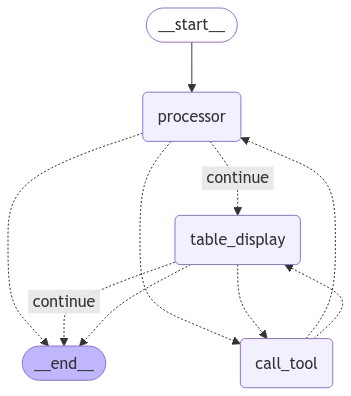

In [86]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [82]:
import json

events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content=f"""Please perform the following two-step process:

                1. Processor:
                - Extract data from the PDF file located at: {PDF_FILE_PATH}
                - Use the following schema to guide your processing:
                    {json.dumps(SCHEMA_1, indent=2)}
                - Use the process_pdf_tool to process the PDF file to extract the data according to the schema.

                2. Table Display:
                - Display the table after the processor has processed the PDF file.

                Please execute these steps in order!
    
                Once you've completed both steps, finish by saying "ETL process complete."
                """
                )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

{'processor': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0GGkx4M1LyBgCR2QRL0pdElm', 'function': {'arguments': '{"file_path":"../example_files/lacers_reduced.pdf"}', 'name': 'process_pdf_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 402, 'total_tokens': 426, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_52a7f40b0b', 'finish_reason': 'tool_calls', 'logprobs': None}, name='processor', id='run-3216336a-76c0-43bd-b6b5-fb0ceddafbb0-0', tool_calls=[{'name': 'process_pdf_tool', 'args': {'file_path': '../example_files/lacers_reduced.pdf'}, 'id': 'call_0GGkx4M1LyBgCR2QRL0pdElm', 'type': 'tool_call'}], usage_metadata={'input_tokens': 402, 'output_tokens': 24, 'total_tokens': 426})], 'sender': 'processor'}}
----
Input Data Type: <class 'list'>
Input Data Content: [{'Firm': ['Spark Capital', 'Genstar Partners', '

In [85]:
display_table()

                  Firm Number_of_Funds Commitment Percent_of_Total_Comm  Exposure Percent_of_Total_Exposure TVPI Net_IRR
         Spark Capital               -       13.3                     -         -                         -    -       -
      Genstar Partners               -       50.0                     -         -                         -    -       -
 Gilde Buyout Partners               -      34.93                     -         -                         -    -       -
      Harvest Partners               -       50.0                     -         -                         -    -       -
                  DEFY               -       18.0                     -         -                         -    -       -
         TA Associates               -       35.0                     -         -                         -    -       -
  Advent International               5       45.0                   2.8 132320692                       3.7 1.64    16.0
        Freeman Spogli          